# FOPRA 34 Report - TUM/LMU MSc QST
*Bartu Bisgin, Soumyadeep Sarkar, Ruipeng Li*

# Simulating Quantum Many-body Dynamics on a Current Digital Quantum Computer




## Introduction

We report the results for our work on the Advanced Lab Course (FOPRA) 34. This practicum was divided into two days. 

Day 1 includes an introduction to the basics of Cirq, Google's quantum language, along with a wide range of generically useful protocols for quantum computing. Demonstrations on generating Bell states, Quantum Teleportation, Rabi Oscillations, Noise-effects and Trotterization are presented. Additionally, an implementation of Single-qubit tomography is explored. Lastly, a 'vanilla' VQE is implemented for approximating the ground state of a simple Hamiltonian, and the resulting state is compared to the known exact solution. Effect of noise on VQE is also explored.

Day 2 focuses on the more advanced concepts of Dynamical Quantum Phase Transitions (DQPTs). Results include a classical magnetization simulation, as well as a trotterized quantum simulation of a 1D Transverse Field Ising (TFI) chain. Loschmidt Rates have been extracted for the quantum simulation and DQPTs have been identified. Investigations into the entanglement production within the system is also presented. The corresponding code for all sections have been included as a git link.

## Day 1

### *1) Error-mitigation on NISQ devices*

Quantum computers promise quantum advantage in the long term. Before such an ambitions could be fulfilled however, fault-tolerance must be achieved; which is projected to be 5-10 years, maybe even decades away.

Nevertheless, academia and industry are working side by side to identify possible hybrid quantum-classical routines that could take advantage of the noisy intermediate scale quantum (NISQ) machines we have today. 

One of the most widely pursued ideas in the NISQ-era is 'Error Mitigation'. The concept of error mitigation can readily be applied to algorithms that rely on outputting expectation values. There are many error-correction schemes. We will be using the 'Calibration & Unfolding' scheme for Day 2, which focuses on fixing read-out errors.

### Exercise 1: Norm-preserving Calibration & Unfolding EC

$v_a' = \sum_{b}{P_{ab}v_b}$

Let $\sum_{a}{|v_a'|} = 1$

then, $\sum_{b}{|v_b|} (\sum_{a}{P_{ab})} = 1$

since $P_{ab}$ is a conditional probability distribution, $\sum_{a}{P_{ab}} = 1$ (?)

thus, $\sum_{b}{|v_b|} = 1$ (?)

### *Cirq* 

Cirq is the quantum circuit SDK developed by Google. Cirq will be the framework of choice for running the following demonstrations.

In [15]:
import cirq

import numpy as np
import matplotlib.pyplot as plt
import random

### *2) Quantum Teleportation*

Quantum Teleportation is a protocol for teleporting a state from one spatial location to the other via. using entanglement.

Given that Alice and Bob shares a maximally entangled state such as an EPR pair ie. a Bell State (for teleportation fidelity, $F=1$); Alice's additional state can be teleported to Bob via. using LOCC.

### Exercise 2: Generate & Measure EPR Pairs

In [16]:
q_0 = cirq.NamedQubit('q_0')
q_1 = cirq.NamedQubit('q_1')
qc = cirq.Circuit()
qc.append([cirq.H(q_0), cirq.CNOT(q_0, q_1)]) # this generates the phi+ state

print(qc)

q_0: ───H───@───
            │
q_1: ───────X───


In [17]:
sv = qc.final_state_vector() # getting the output statevector of the vector we can see indeed this is the phi+
print(np.around(sv, 3))

[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


In [18]:
### Generalizing as a fn. to be able to create all 4 Bell States
def bell_generator(index):

    q_0 = cirq.NamedQubit('q_0')
    q_1 = cirq.NamedQubit('q_1')
    qc = cirq.Circuit()

    qc.append([cirq.H(q_0), cirq.CNOT(q_0, q_1)])

    if index == 1:
        #create bell_1
        pass
    elif index == 2:
        qc.insert(0, [cirq.X(q_0)])
    elif index == 3:
        qc.insert(0, [cirq.X(q_1)])
    elif index == 4:
        qc.insert(0, [cirq.X(q_0), cirq.X(q_1)])

    return qc


In [19]:
# index: {1,2,3,4} corresponds to
# bell state: {phi+, phi-, psi+, psi-} respectively

for i in range(1,5):
    bell_i = bell_generator(i)
    print('Bell circuit no:', i)
    print(bell_i)


Bell circuit no: 1
q_0: ───H───@───
            │
q_1: ───────X───
Bell circuit no: 2
q_0: ───X───H───@───
                │
q_1: ───────────X───
Bell circuit no: 3
q_0: ───H───@───
            │
q_1: ───X───X───
Bell circuit no: 4
q_0: ───X───H───@───
                │
q_1: ───X───────X───


In [20]:
# And how to measure an unknown Bell state?
# We need a Bell measurement
# Basically transform the basis into the bell basis before measuring

def bell_meas(qc):
    qc.append([cirq.CNOT(q_0, q_1), cirq.H(q_0), cirq.measure(q_0, q_1)])
    

In [21]:
print(qc)

q_0: ───H───@───
            │
q_1: ───────X───


In [22]:
# let's not generate and measure phi+ 
# we should end up with the |00>

q_0 = cirq.NamedQubit('q_0')
q_1 = cirq.NamedQubit('q_1')

qc = bell_generator(1)

bell_meas(qc)
print(qc)


q_0: ───H───@───@───H───M───
            │   │       │
q_1: ───────X───X───────M───


In [23]:
qc.final_state_vector() #indeed we see we get back |00> in vector form

array([ 1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j])

In [24]:
for i in range(1,5):
    qc = bell_generator(i)
    bell_meas(qc)

    sv = qc.final_state_vector()
    print('the final statevector for bell state', i, 'is:')
    print(sv)

# phi+ gives 00
# phi- gives 10
# psi+ gives 01
# psi- gives 11

the final statevector for bell state 1 is:
[ 1.+0.j  0.+0.j -0.+0.j -0.+0.j]
the final statevector for bell state 2 is:
[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
the final statevector for bell state 3 is:
[ 0.+0.j  1.+0.j -0.+0.j -0.+0.j]
the final statevector for bell state 4 is:
[0.+0.j 0.+0.j 0.+0.j 1.+0.j]


### Exercise 3: LOCC 

When Alice performs a Bell measurement on her qubits, with $P=1/4$ she will receive the 00, 01, 10 or 11. These results correspond to teleportation of Alice's sate to Bob in the following manner:

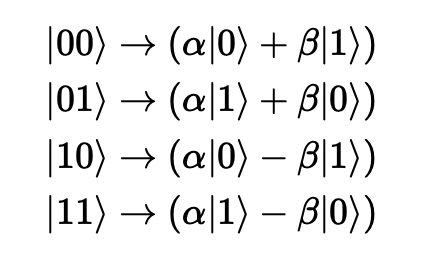

Depending on the classical measurement results Alice has, Bob can recover the state using only 1 $CNOT$ and 1 $CZ$ in the following scheme:

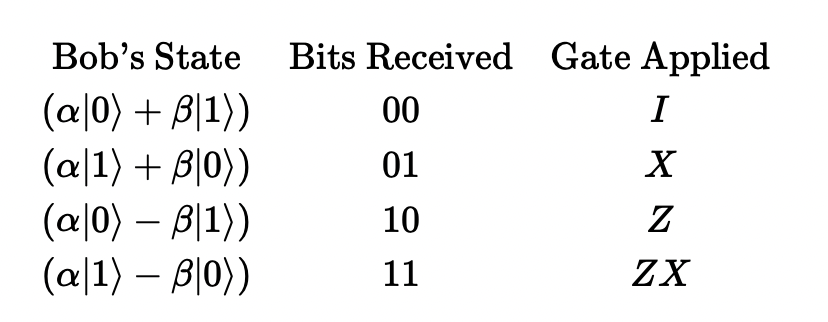

**Image Credit:** [Qiskit Textbook](https://qiskit.org/textbook/ch-algorithms/teleportation.html)

### Exercise 4: Simulation of Quantum Teleport

In [25]:
def make_quantum_teleportation_circuit(gate): # the variable 'gate' here stands for the state to be sent ie. message
    circuit = cirq.Circuit()

    # Get the three qubits involved in the teleportation protocol.
    msg = cirq.NamedQubit("Message")
    alice = cirq.NamedQubit("Alice")
    bob = cirq.NamedQubit("Bob")

    # to create the initial random state for Alice
    circuit.append(gate(msg))

    # Bell state
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])

    # Bell measurement
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg), cirq.measure(msg, alice)])

    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum message on Bob's entangled qubit
    circuit.append([cirq.CNOT(alice, bob), cirq.CZ(msg, bob)])

    return circuit

In [26]:
"""Visualize the teleportation circuit."""
# Gate to put the message qubit in some state to send.
gate = cirq.X ** 0.25

# Create the teleportation circuit.
circuit = make_quantum_teleportation_circuit(gate)
print("Teleportation circuit:\n")
print(circuit)

Teleportation circuit:

Alice: ─────H────────@───X───────M───@───────
                     │   │       │   │
Bob: ────────────────X───┼───────┼───X───@───
                         │       │       │
Message: ───X^0.25───────@───H───M───────@───


In [27]:
"""Display the Bloch vector of the message qubit."""
message = cirq.Circuit(gate.on(cirq.NamedQubit("Message"))).final_state_vector()
message_bloch_vector = cirq.bloch_vector_from_state_vector(message, index=0)
print("Bloch vector of message qubit:")
print(np.round(message_bloch_vector, 3))

Bloch vector of message qubit:
[ 0.    -0.707  0.707]


In [28]:
"""Simulate the teleportation circuit and get the final state of Bob's qubit."""
sim = cirq.Simulator()

# Simulate the teleportation circuit.
result = sim.simulate(circuit)

# Get the Bloch vector of Bob's qubit.
bobs_bloch_vector = cirq.bloch_vector_from_state_vector(result.final_state_vector, index=1)
print("Bloch vector of Bob's qubit:")
print(np.round(bobs_bloch_vector, 3))

# Verify they are the same state!
np.testing.assert_allclose(bobs_bloch_vector, message_bloch_vector, atol=1e-7)

Bloch vector of Bob's qubit:
[ 0.    -0.707  0.707]


## *3) Rabi Oscillations*

Rabi Oscillations are observed when we drive a two-level system coherently and periodically between it's ground and excited states $|0>$ and $|1>$. For the experimental setting, it plays an important role in demonstrating, one indeed has a usable qubit over which single-qubit gates can be performed.

### Exercise 5: Populations

$P_{0} = |\alpha|^2 = \cos^2{(\Omega*t/2)} + (\Delta/\Omega)^2 * \sin^2{(\Omega*t/2)}$

$P_{1} = |\beta|^2 = (\omega_{1}/\Omega)^2 \sin^2{(\Omega*t/2)}$

### Exercise 6: Trotterization

In [29]:
def U_t(q, w0, w1, w, dt, trotter_steps): # defining a fully-parameterized trotterization

    for n in range(trotter_steps):
        yield cirq.rx(2*w1*dt*np.cos(w*n*dt)).on(q)
        yield cirq.rz(-w0*dt).on(q)

    yield cirq.measure(q, key='out')

(0.0, 1000.0)

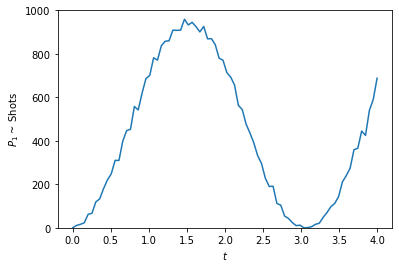

In [30]:
# a) use the following parameters with run method

w1 = 2
w0 = 25
w = 25.5
dt = 0.05
time = np.linspace(0, 4, 80)
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []

for t in time:
    trotter = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    sim = cirq.Simulator()
    result = sim.run(trotter, repetitions=1000)
    prob_1.append(np.mean(result.histogram(key='out')[1]))

plt.plot(time, prob_1)
plt.xlabel('$t$')
plt.ylabel('$P_1$ ~ Shots')
plt.ylim((0,1000))



(0.0, 1.0)

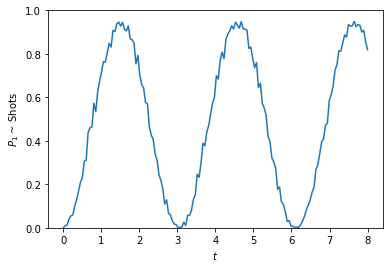

In [31]:
w1 = 2
w0 = 25
w = 25.5
dt = 0.05
t_max = 8
time = np.linspace(0, t_max, int(t_max/dt))
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []

for t in time:
    qc = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    sim = cirq.Simulator()
    result = cirq.sample(qc, repetitions=1000)
    prob = result.histogram(key='out')
    prob_1.append(prob[1]/1000)

plt.plot(time, prob_1)
plt.xlabel('$t$')
plt.ylabel('$P_1$ ~ Shots')
plt.ylim((0,1))

(0.0, 1.0)

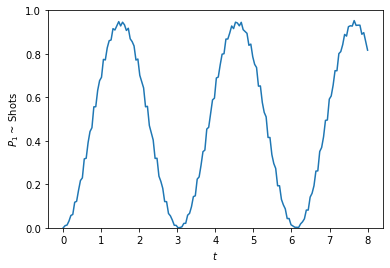

In [32]:
# Another alternative is to directly get the final statevector from qc

w1 = 2
w0 = 25
w = 25.5
dt = 0.05
t_max = 8
time = np.linspace(0, t_max, int(t_max/dt))
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []

for t in time:
    qc = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    sv = qc.final_state_vector()
    prob = np.abs(sv[1])**2
    prob_1.append(prob)

plt.plot(time, prob_1)
plt.xlabel('$t$')
plt.ylabel('$P_1$ ~ Shots')
plt.ylim((0,1))

(0.0, 1.0)

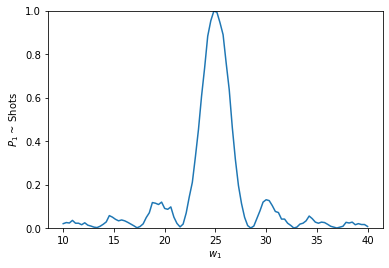

In [33]:
# b) with different detunings, fixed time

w1 = 2
w0 = 25
w_ext = np.linspace(10, 40, 100)
dt = 0.05
t = np.pi / w1
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []

for w in w_ext:
    qc = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    sim = cirq.Simulator()
    result = sim.run(qc, repetitions=1000)
    prob_1.append(result.histogram(key='out')[1]/1000)

plt.plot(w_ext, prob_1)
plt.xlabel('$w_1$')
plt.ylabel('$P_1$ ~ Shots')
plt.ylim((0,1))

(0.0, 1.0)

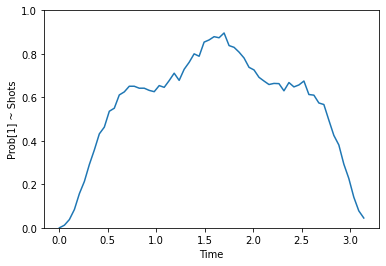

In [34]:
# c)

w1 = 2
w0 = 2
w = 2
dt = 0.05
t_max = np.pi
time = np.linspace(0, t_max, int(t_max/dt))
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []

for t in time:
    qc = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    qc.append(cirq.measure(q_0, key='z'))
    
    sim = cirq.Simulator()
    result = sim.run(qc, repetitions=1000)
    prob_1.append(np.mean(result.measurements['z']))

plt.plot(time, prob_1)
plt.xlabel('Time')
plt.ylabel('Prob[1] ~ Shots')
plt.ylim((0,1))

### Exercise 7: Noise & Damped Rabi Oscillations

NISQ devices are very noisy with myriads of different noise sources and thus, noise profiles. Thus, the ability to incorporate noise in a controlled manner into our noiseless quantum circuit is important. Through this, we can gain insight as to how real noise could affect our circuit outputs.

Text(0.5, 0.98, 'Noisy Simulation')

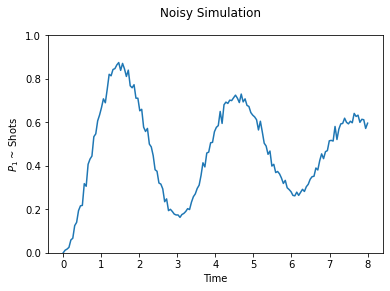

In [35]:
# Exercise 7: Noise & Damped Rabi Oscillations
p = 0.9
gamma =0.005
noise = cirq.ConstantQubitNoiseModel(
            cirq.GeneralizedAmplitudeDampingChannel(p,gamma))

w1 = 2
w0 = 25
w = 25.5
dt = 0.05
t_max = 8
time = np.linspace(0, t_max, int(t_max/dt))
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []

for t in time:
    trotter = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    result = cirq.sample(trotter, noise=noise, repetitions=1024)
    prob = result.histogram(key='out')
    prob_1.append(prob[1]/1000)

plt.plot(time, prob_1)
plt.xlabel('Time')
plt.ylabel('$P_1$ ~ Shots')
plt.ylim((0,1))
plt.suptitle('Noisy Simulation')


## *4) State Tomography*

Cirq only allows us to measure along the z basis. To measure along other bases, appropriate transformations are required. The transformations are generic:

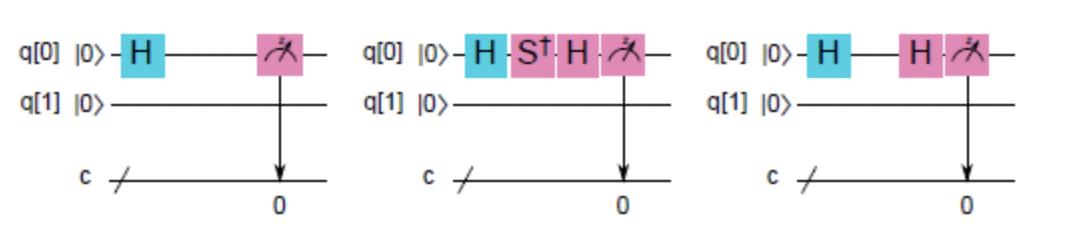

**Image Credit:** [qc-stackexchange](https://quantumcomputing.stackexchange.com/questions/13605/how-to-measure-in-another-basis)

However, since $S^{\dagger}$ does not exists in Cirq as baseline, we defined it.

The same is true for the y basis, the operator we use is the product of phase gate and Hadamard gate. We find the averages by simulating the circuits and get the mean of our measured results. Since we only measure the '0's and '1's we have to map these to the eigenvalues 1 and -1. 

In [36]:
# define S_dagger gate which doesn't exist in Cirq
class S_dag_Gate(cirq.Gate):
    def __init__(self):
        super(S_dag_Gate, self)

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        return np.array([[1,0],[0, -1j]])

    def _circuit_diagram_info_(self, args):
        return "S_dag"
    
S_dag = S_dag_Gate()

s_dag_cirq = cirq.Circuit(S_dag(q_0))
print(s_dag_cirq)

q_0: ───S_dag───


In [45]:
def single_qubit_tomography(sampler, qubit, circuit, repetitions):
    qc_z = cirq.Circuit(circuit, cirq.ops.measure(qubit, key='z'))
    results = sampler.run(qc_z, repetitions=repetitions)
    rho_11 = np.mean(results.measurements['z'])
    rho_00 = 1.0 - rho_11

    qc_x = cirq.Circuit(circuit, cirq.ops.H(qubit), cirq.ops.measure(qubit, key='z'))
    results = sampler.run(qc_x, repetitions=repetitions)
    rho_01_im = np.mean(results.measurements['z'])

    qc_y = cirq.Circuit(circuit, S_dag(qubit), cirq.H(qubit), cirq.ops.measure(qubit, key='z'))
    results = sampler.run(qc_y, repetitions=repetitions)
    rho_01_re = np.mean(results.measurements['z'])

    rho_01 = rho_01_re + rho_01_im*1j
    rho_10 = np.conj(rho_01)

    rho = np.array([[rho_00, rho_01],
                    [rho_10, rho_11]])

    return rho

In [46]:
sampler = cirq.Simulator()
qubit = cirq.NamedQubit('qubit')
qc = cirq.Circuit([cirq.H(qubit)])
repetitions = 10000

print(qc)
single_qubit_tomography(sampler, qubit, qc, repetitions)

qubit: ───H───


array([[0.5007+0.j, 0.4917+0.j],
       [0.4917-0.j, 0.4993+0.j]])

In [47]:
result = cirq.experiments.single_qubit_state_tomography(sampler, qubit, qc, repetitions)
result.data

array([[0.4985+0.j    , 0.5   -0.0038j],
       [0.5   +0.0038j, 0.5015+0.j    ]])

### Exercise 9: State Tomography of a given state

In [48]:
# The given state can be produced from a Hadamard and then a Phase gate
# For a single qubit, Phase gate can be implemented by R_z up to a global phase

qc_ex_9 = cirq.Circuit(qc, cirq.rz(np.pi/2).on(qubit))
print(qc_ex_9)
sv = qc_ex_9.final_state_vector()
print(cirq.qis.dirac_notation(sv))

#single_qubit_tomography(sampler, qubit, qc, repetitions)

qubit: ───H───Rz(0.5π)───
(0.5-0.5j)|0⟩ + (0.5+0.5j)|1⟩


### Exercise 10: Reconstruction from Tomography

We want to create the 

(0.0, 1.0)

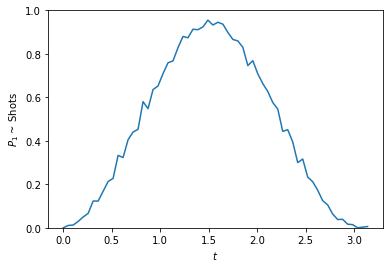

In [49]:
# Exercise 10: Reconstruct Ex.6 with Tomography

w1 = 2
w0 = 25
w = 25.5
dt = 0.05
t_max = 3.14
time = np.linspace(0, t_max, int(t_max/dt))
# alternatively, trotter_steps = np.arange(0, int(4/dt), 1)

q_0 = cirq.NamedQubit('q_0')

prob_1 = []
sampler = cirq.Simulator()

for t in time:
    trotter = cirq.Circuit(U_t(q_0, w0, w1, w, dt, trotter_steps = int(t/dt)))
    rho = single_qubit_tomography(sampler, q_0, trotter, repetitions=1024)
    prob = np.abs(rho[1,1])
    prob_1.append(prob)

plt.plot(time, prob_1)
plt.xlabel('$t$')
plt.ylabel('$P_1$ ~ Shots')
plt.ylim((0,1))


We can see the expected behaviour of $P_1 = (\omega_1 / \Omega)^2 * sin^2{(\Omega*t/2)}$

## *5) Variational Quantum Eigensolver*

One of the most popular NISQ-era Algorithms is the so-called Variational Quantum Eigensolver (VQE).

Based on the Variational Principle, VQE aims to approximate the ground-state energy of a system through evaluating an Ansatz ie. a trial wave-function which is parameterized. Evaluating such parameterized wave-functions is exponentially hard in system size for classical computers, whereas it is far more trivial for quantum computers.

At each evaluation of the circuit, the parameters are optimized to result in a lower energy. Here we don't use an optimizer, but simply find the minimum ourselves through a heat-map plotting.

In [51]:
# Ansatz -- Z1 and Z2 commutes, so does Z1 ^ X2 and X1 ^ Z2
# then we can take the sums as simple products
# Let's first define the RZZ gate

class RZZ_Gate(cirq.Gate):
    def __init__(self, theta):
        super(RZZ_Gate, self)
        self.theta = theta

    def _num_qubits_(self):
        return 2

    def _unitary_(self):
        return np.array([[np.exp(-1j*self.theta/2),np.exp(1j*self.theta/2)],
                        [np.exp(1j*self.theta/2), np.exp(-1j*self.theta/2)]])

    def _circuit_diagram_info_(self, args):
        return [f"R_ZZ({np.around(self.theta,5)})"] * 2

qc = cirq.Circuit(RZZ_Gate(theta=np.pi).on(q_0, q_1))


In [52]:
print(qc)

q_0: ───R_ZZ(3.14159)───
        │
q_1: ───R_ZZ(3.14159)───


In [53]:
# We could also make RZZ from 2 CNOTs and 1 RZ

ansatz = cirq.Circuit()

### Exercise 11: Ansatz

In [54]:
# ended up using the ZZPow gate instead of the RZZ we've defined
# couldn't solve some bugs

def ansatz_circuit(q_0, q_1, a, b):
    
    yield cirq.H(q_1)
    yield cirq.ZZPowGate(exponent=2/np.pi * b, global_shift=-0.5).on(q_0, q_1)
    yield cirq.H(q_1)

    yield cirq.H(q_0)
    yield cirq.ZZPowGate(exponent=2/np.pi * b, global_shift=-0.5).on(q_0, q_1)
    yield cirq.H(q_0)

    yield cirq.ZPowGate(exponent=2/np.pi*a, global_shift=-0.5).on(q_0)
    yield cirq.ZPowGate(exponent=2/np.pi*a, global_shift=-0.5).on(q_1)

### Exercise 12: Running VQE

-1.992


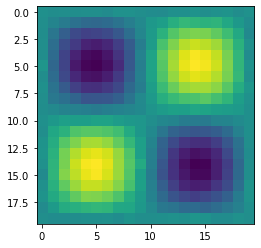

In [66]:
a_list = list(np.linspace(0, np.pi, 20))
b_list = list(np.linspace(0, np.pi, 20))

q_0 = cirq.NamedQubit('q_0')
q_1 = cirq.NamedQubit('q_1')

sim = cirq.Simulator()

H_expec_list = np.zeros((20,20))
results_zx = []
results_xz = []

for a in a_list:
    for b in b_list:
        ansatz = cirq.Circuit(ansatz_circuit(q_0, q_1, a, b))
        # measure Z1 X2 ie. qubit 0 in Z, qubit 1 in X basis
        zx_cirq = cirq.Circuit(ansatz, cirq.H(q_1), cirq.measure(q_0, q_1, key='zx'))
        
        result_zx = sim.run(zx_cirq, repetitions=1000)
        results_zx = 4*(result_zx.measurements['zx'][:,0]-0.5) * (result_zx.measurements['zx'][:,1]-0.5)
        
        zx_expec = np.mean(results_zx)
        
        # measure X1 Z2
        xz_cirq = cirq.Circuit(ansatz, cirq.H(q_0), cirq.measure(q_0, q_1, key='xz'))
        
        result_xz = sim.run(xz_cirq, repetitions=1000)
        results_xz = 4*(result_xz.measurements['xz'][:,0]-0.5) * (result_xz.measurements['xz'][:,1]-0.5)
        
        xz_expec = np.mean(results_xz)
        
        # get the Hamiltonian expectation value
        H_expec = -xz_expec -zx_expec
        H_expec_list[a_list.index(a), b_list.index(b)] = H_expec

        
        
plt.imshow(H_expec_list)       
print(np.min(H_expec_list))

The expected minimum energy $E_{min} = -1.992$

In [67]:
# the minimum is located in the (14,14) element, we can confirm via:

np.argmin(H_expec_list)
H_expec_list[14][14]

-1.992

In [64]:
H_expec_list[14][14] # now getting the min a, b values from this element
a_min = a_list[14]
b_min = b_list[14]
a_min,b_min

(2.3148577447503738, 2.3148577447503738)

### Exercise 13: State Verification


Now that we got the corresponding optimal a and b values, we can run the ansatz ciruit with these specific parameters to find the state corresponding to $E_{min}$, which results in:

In [65]:
optimal_vqe = cirq.Circuit(ansatz_circuit(q_0, q_1, a_min, b_min))
result = sim.simulate(optimal_vqe).dirac_notation()
result

'(-0.04+0.46j)|00⟩ + 0.5j|01⟩ + 0.5j|10⟩ + (-0.04-0.54j)|11⟩'

Comparing to the given state, we can see besides a very slight deviaton, we almost ended up in the exact ground state of the system.

### Exercise 14: Effect of Noise in VQE

-1.902


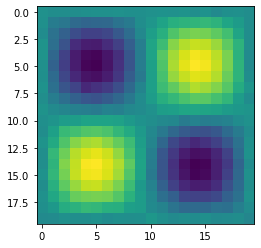

In [69]:
a_list = list(np.linspace(0, np.pi, 20))
b_list = list(np.linspace(0, np.pi, 20))

q_0 = cirq.NamedQubit('q_0')
q_1 = cirq.NamedQubit('q_1')

sim = cirq.Simulator()

H_expec_list = np.zeros((20,20))
results_zx = []
results_xz = []

for a in a_list:
    for b in b_list:
        ansatz = cirq.Circuit(ansatz_circuit(q_0, q_1, a, b))
        
        zx_cirq = cirq.Circuit(ansatz, cirq.H(q_1), cirq.measure(q_0, q_1, key='zx'))
        
        result_zx = cirq.sample(zx_cirq, noise=noise, repetitions=1000) # we add noise
        results_zx = 4*(result_zx.measurements['zx'][:,0]-0.5) * (result_zx.measurements['zx'][:,1]-0.5)
        
        zx_expec = np.mean(results_zx)

        xz_cirq = cirq.Circuit(ansatz, cirq.H(q_0), cirq.measure(q_0, q_1, key='xz'))
        
        result_xz = cirq.sample(xz_cirq, noise=noise, repetitions=1000) # we add noise
        results_xz = 4*(result_xz.measurements['xz'][:,0]-0.5) * (result_xz.measurements['xz'][:,1]-0.5)
        
        xz_expec = np.mean(results_xz)
        
        H_expec = -xz_expec -zx_expec
        H_expec_list[a_list.index(a), b_list.index(b)] = H_expec

print(np.min(H_expec_list))     
plt.imshow(H_expec_list)       


We can see that the energy change is not so dramatic and hence VQE is to an extent, robust against the effect noise.